In [1]:
## install git and configure(so we know who commit the code)
# !apt-get install git
# !git config --global user.name "USER_NAME"
# !git config --global user.email "EMAIL"

# access google drive
# from google.colab import drive
# drive.mount('/content/drive')

# clone repo
!git clone https://github.com/Mu-niu13/Image-Translation-CycleGAN.git
%cd Image-Translation-CycleGAN

# set up personal access for push/pull
from getpass import getpass
token = getpass('Enter your GitHub PAT:')
!git remote set-url origin https://{token}@github.com/Mu-niu13/Image-Translation-CycleGAN.git

Cloning into 'Image-Translation-CycleGAN'...
remote: Enumerating objects: 1220, done.
remote: Counting objects: 100% (1220/1220), done.
remote: Compressing objects: 100% (1214/1214), done.
remote: Total 1220 (delta 5), reused 1216 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (1220/1220), 33.75 MiB | 25.45 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/Image-Translation-CycleGAN
Enter your GitHub PAT:··········


In [6]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
from lib.models import ProgressiveGenerator, ProgressiveDiscriminator
from lib.losses import (
    discriminator_loss, generator_loss, cycle_consistency_loss, identity_loss
)
from lib.data_loader import *
import matplotlib.pyplot as plt  # Import matplotlib
import numpy as np
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create directories
os.makedirs('checkpoints', exist_ok=True)

Training at scale: 64x64
Files already downloaded and verified


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1/5] Loss_G: 8.7290 Loss_D_X: 0.3558 Loss_D_Y: 0.2479


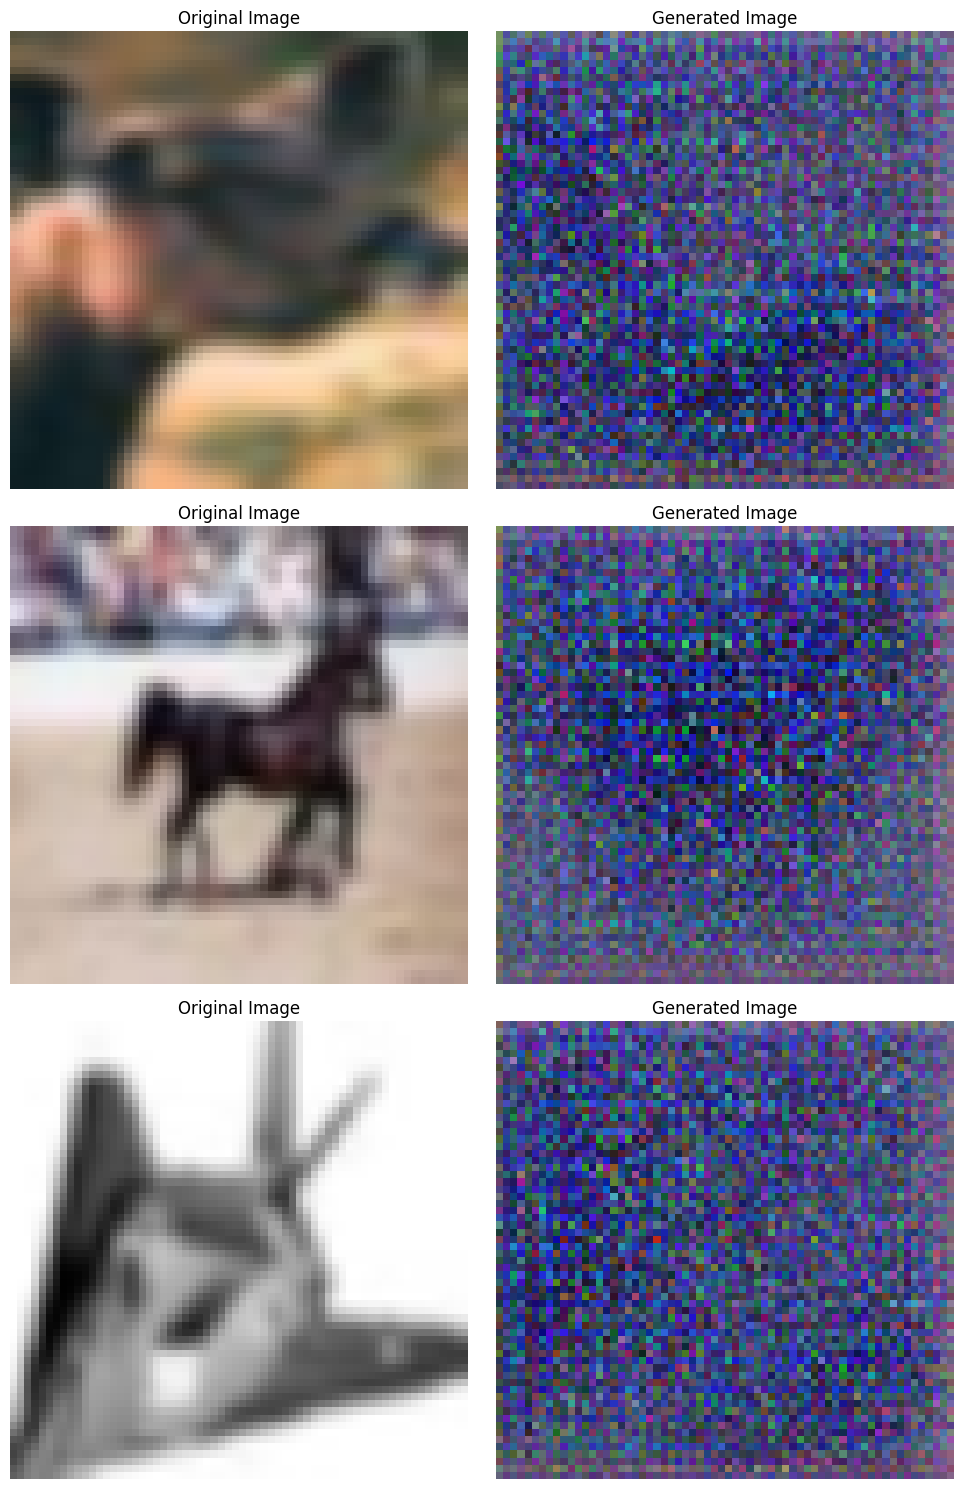

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/5] Loss_G: 8.7290 Loss_D_X: 0.3558 Loss_D_Y: 0.2479


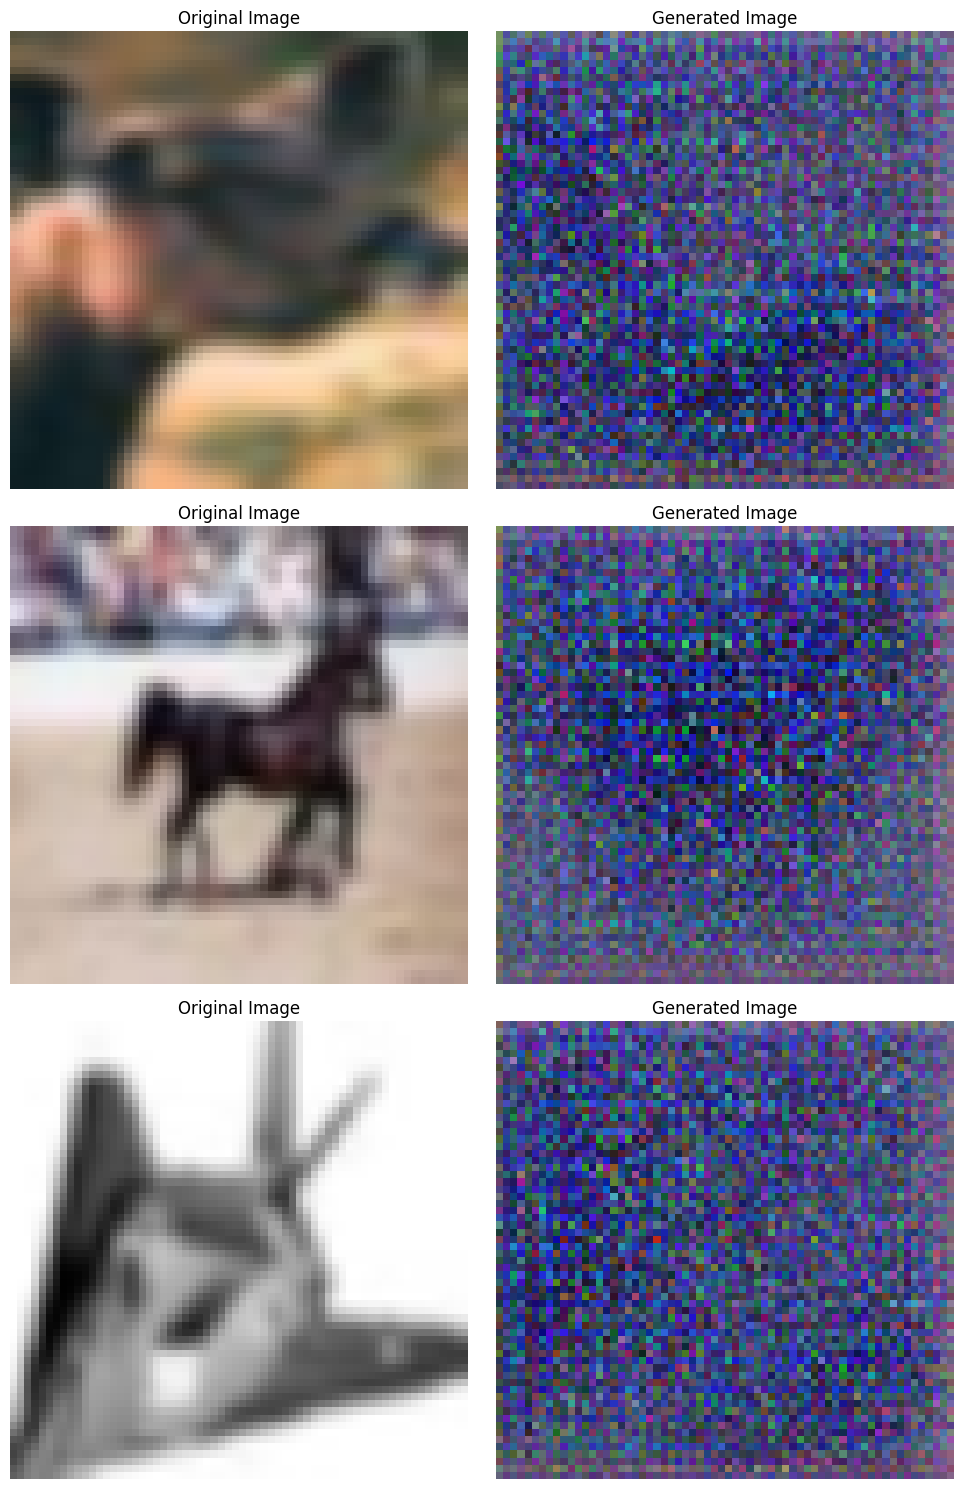

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/5] Loss_G: 8.7290 Loss_D_X: 0.3558 Loss_D_Y: 0.2479


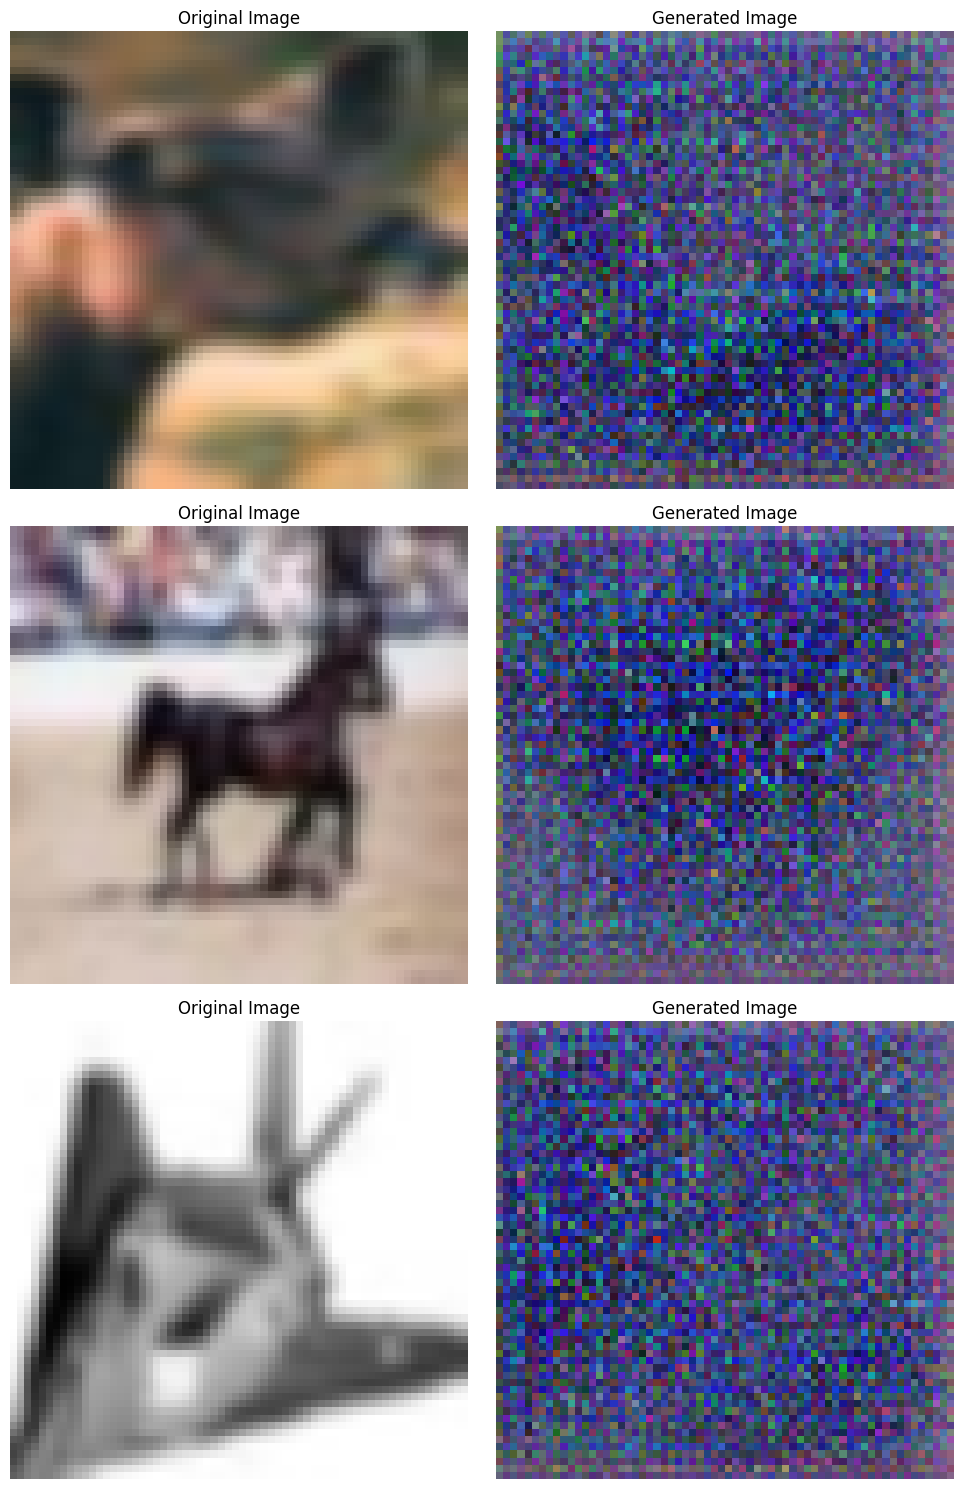

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/5] Loss_G: 8.7290 Loss_D_X: 0.3558 Loss_D_Y: 0.2479


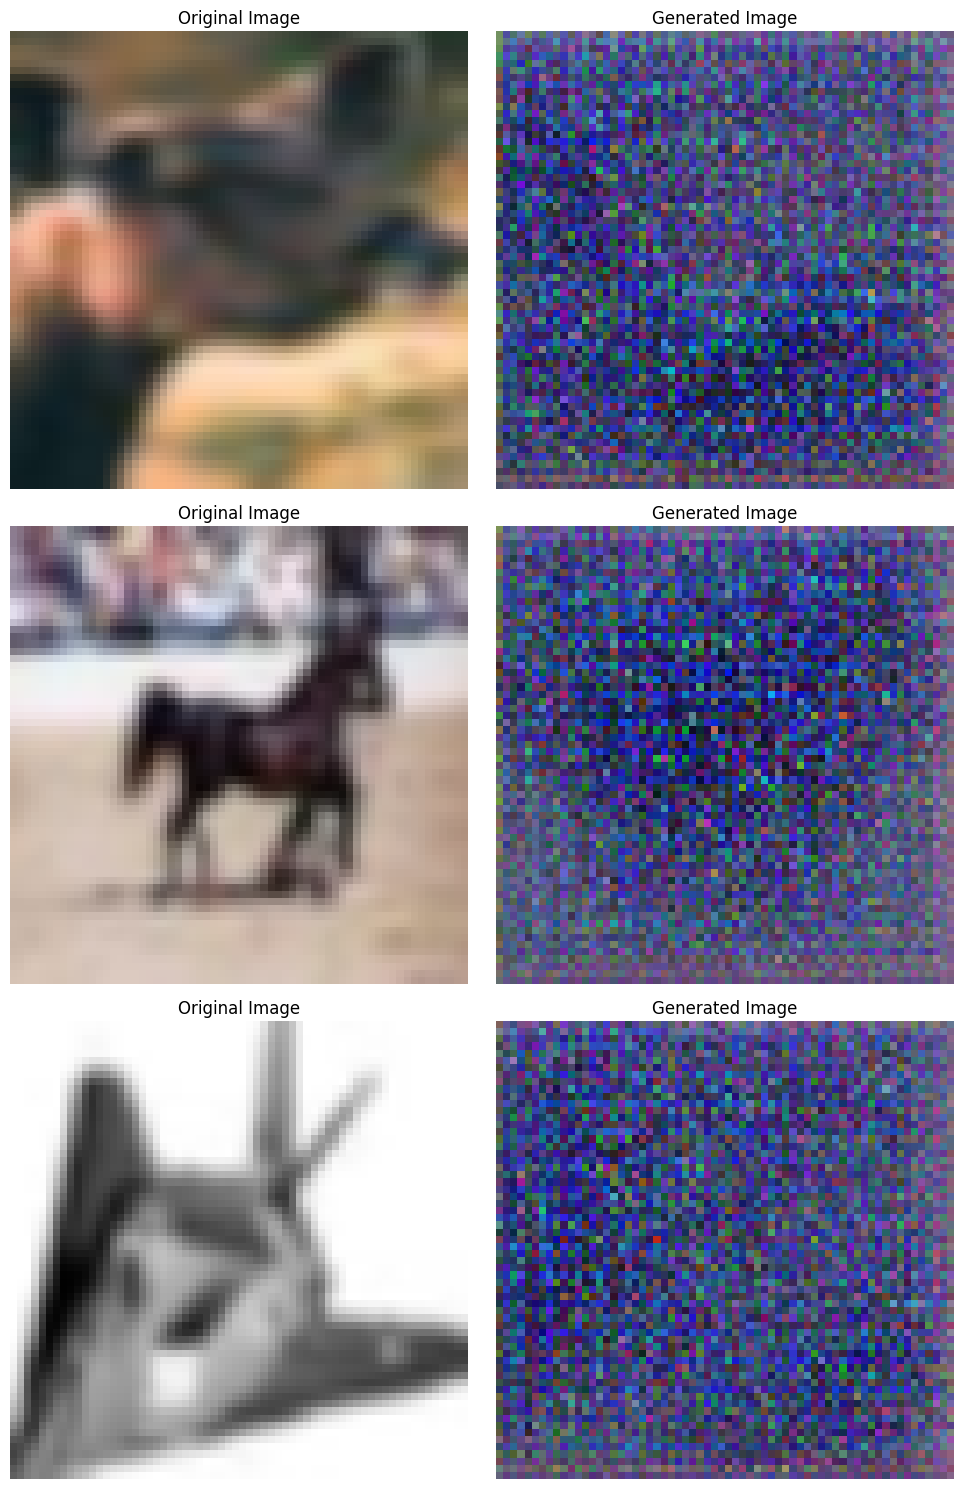

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/5] Loss_G: 8.7290 Loss_D_X: 0.3558 Loss_D_Y: 0.2479


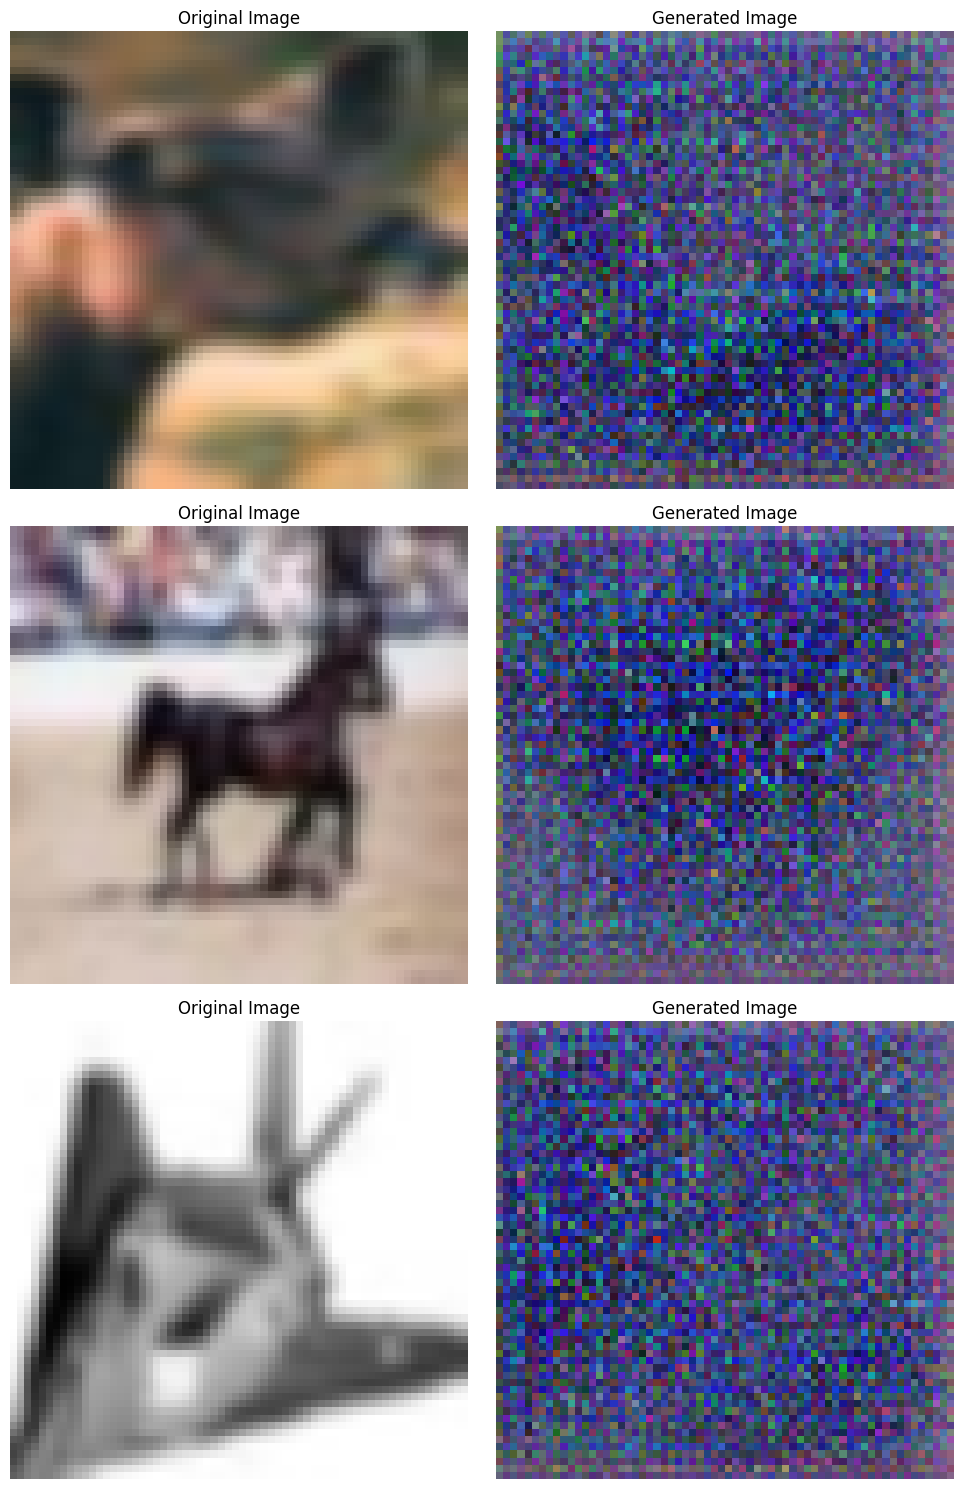

Training at scale: 128x128
Files already downloaded and verified


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1/5] Loss_G: 9.1433 Loss_D_X: 0.1928 Loss_D_Y: 0.1987


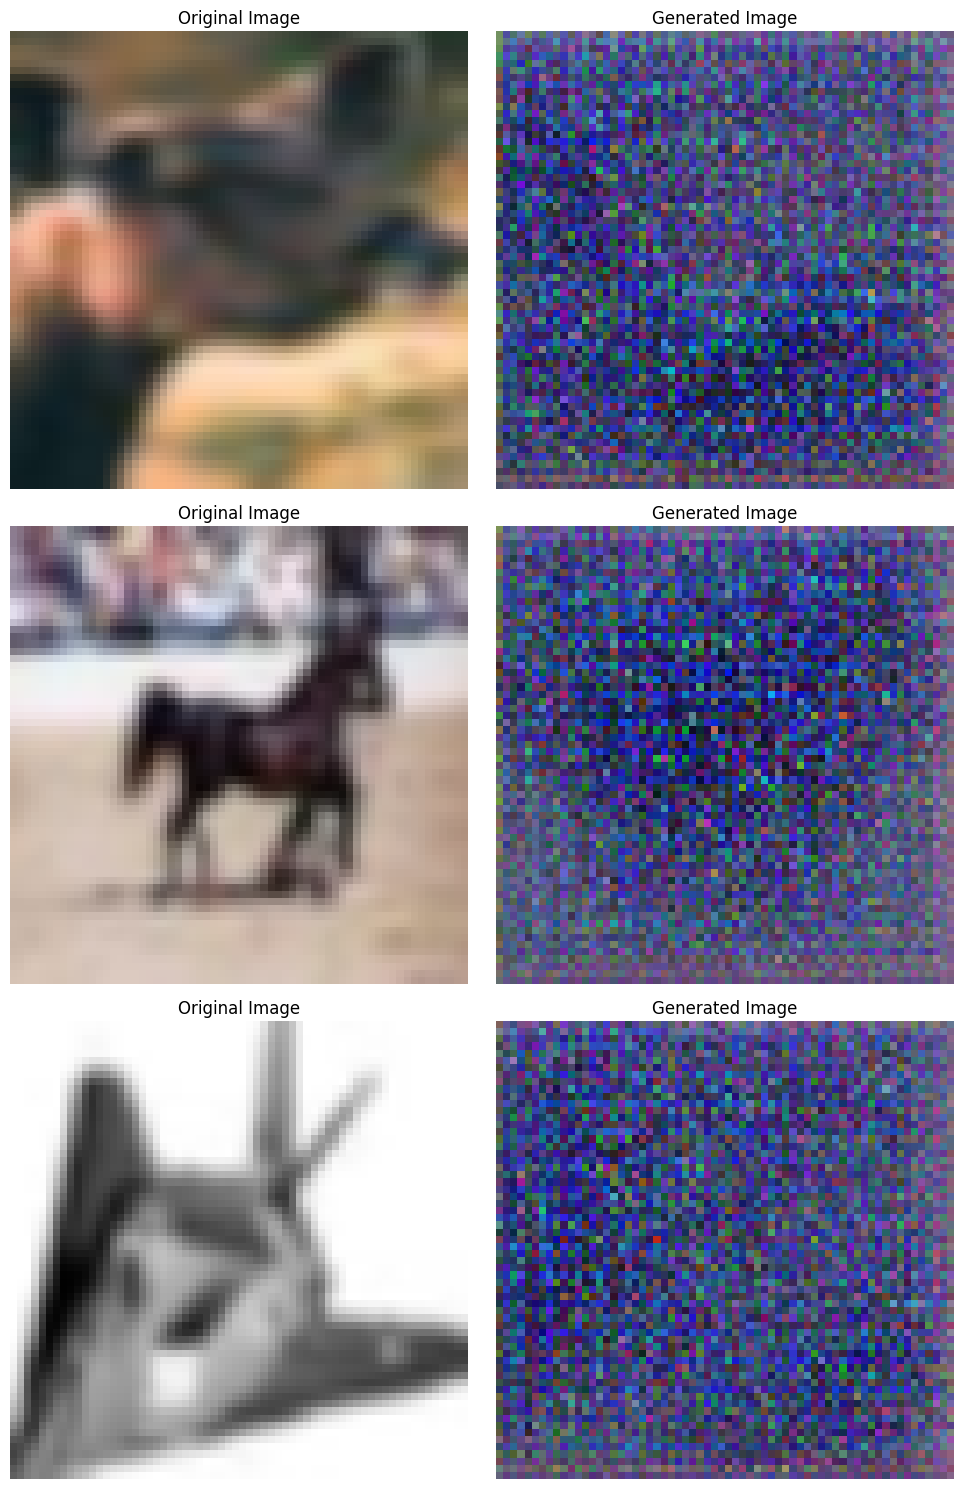

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/5] Loss_G: 9.1433 Loss_D_X: 0.1928 Loss_D_Y: 0.1987


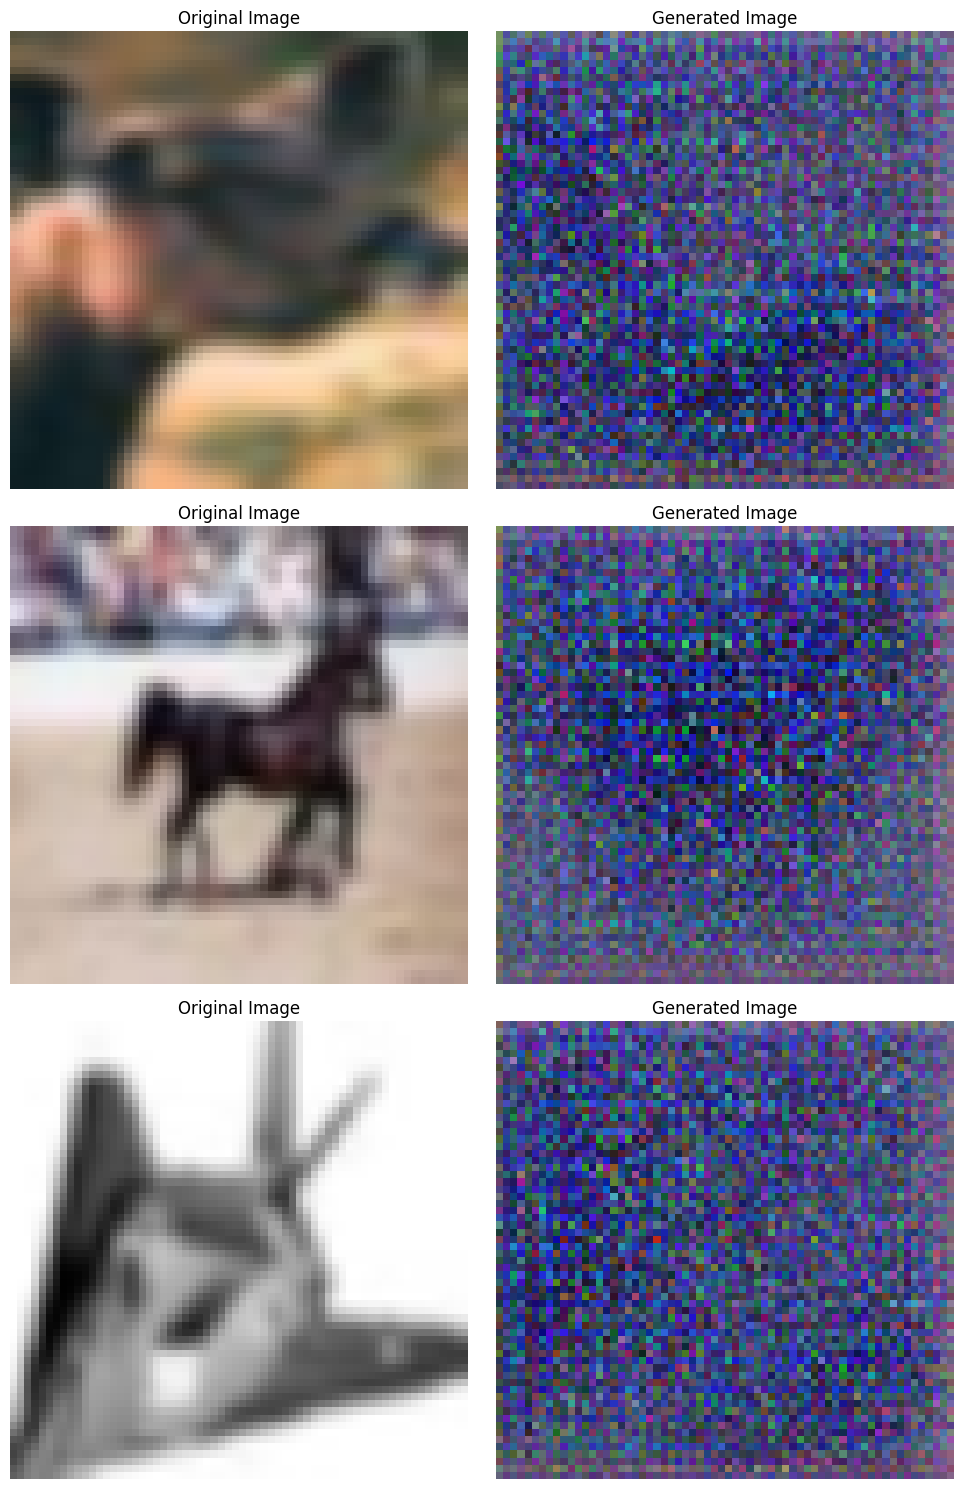

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/5] Loss_G: 9.1433 Loss_D_X: 0.1928 Loss_D_Y: 0.1987


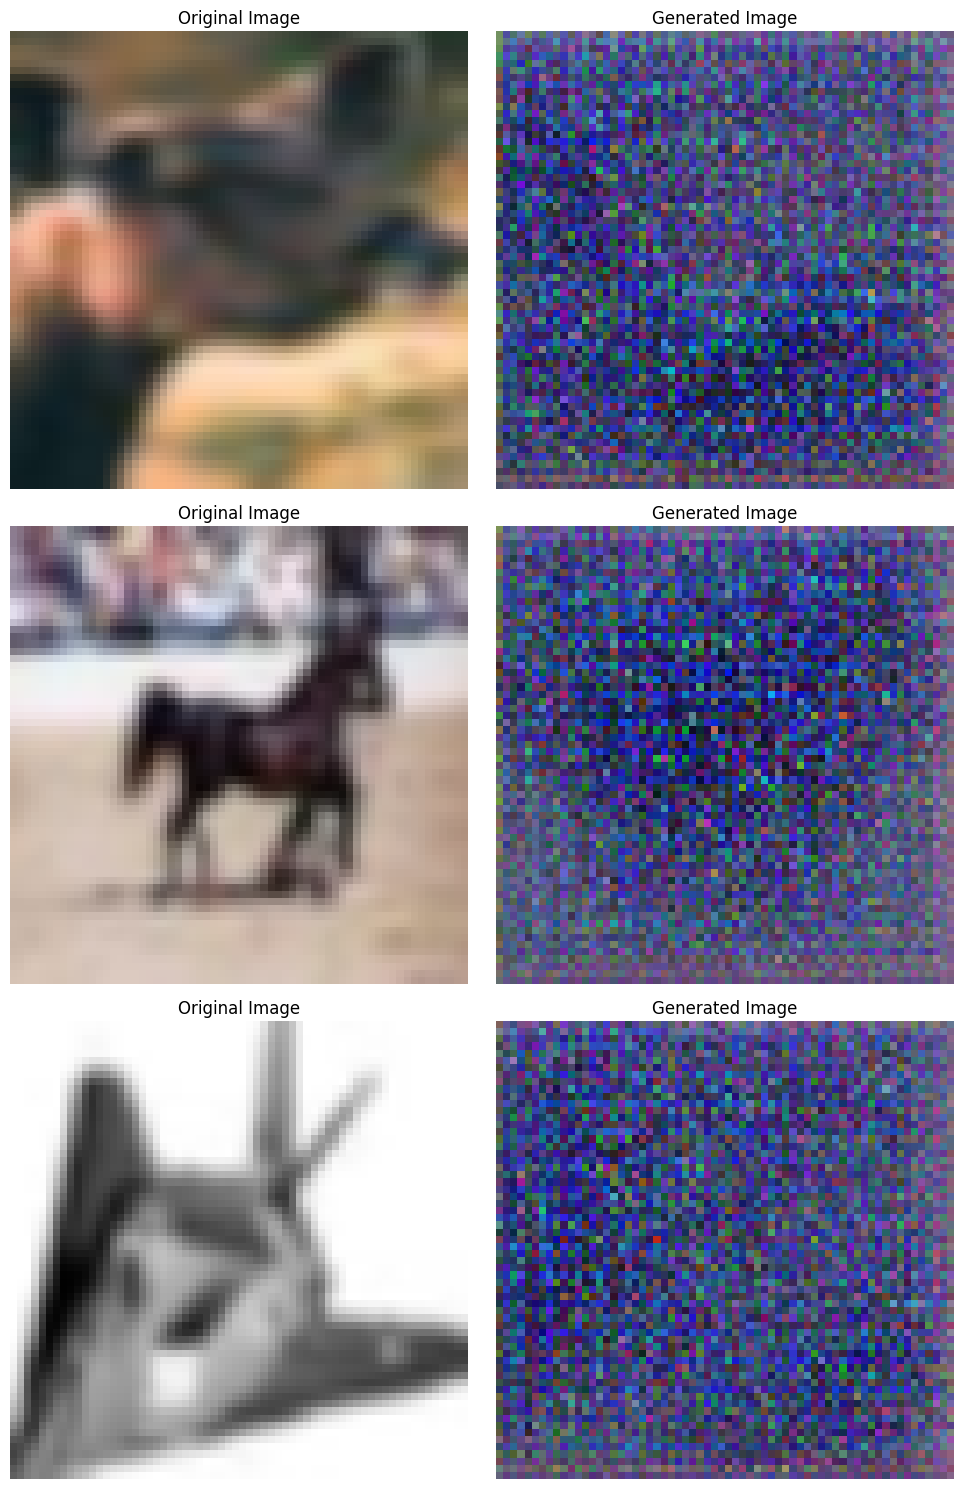

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/5] Loss_G: 9.1433 Loss_D_X: 0.1928 Loss_D_Y: 0.1987


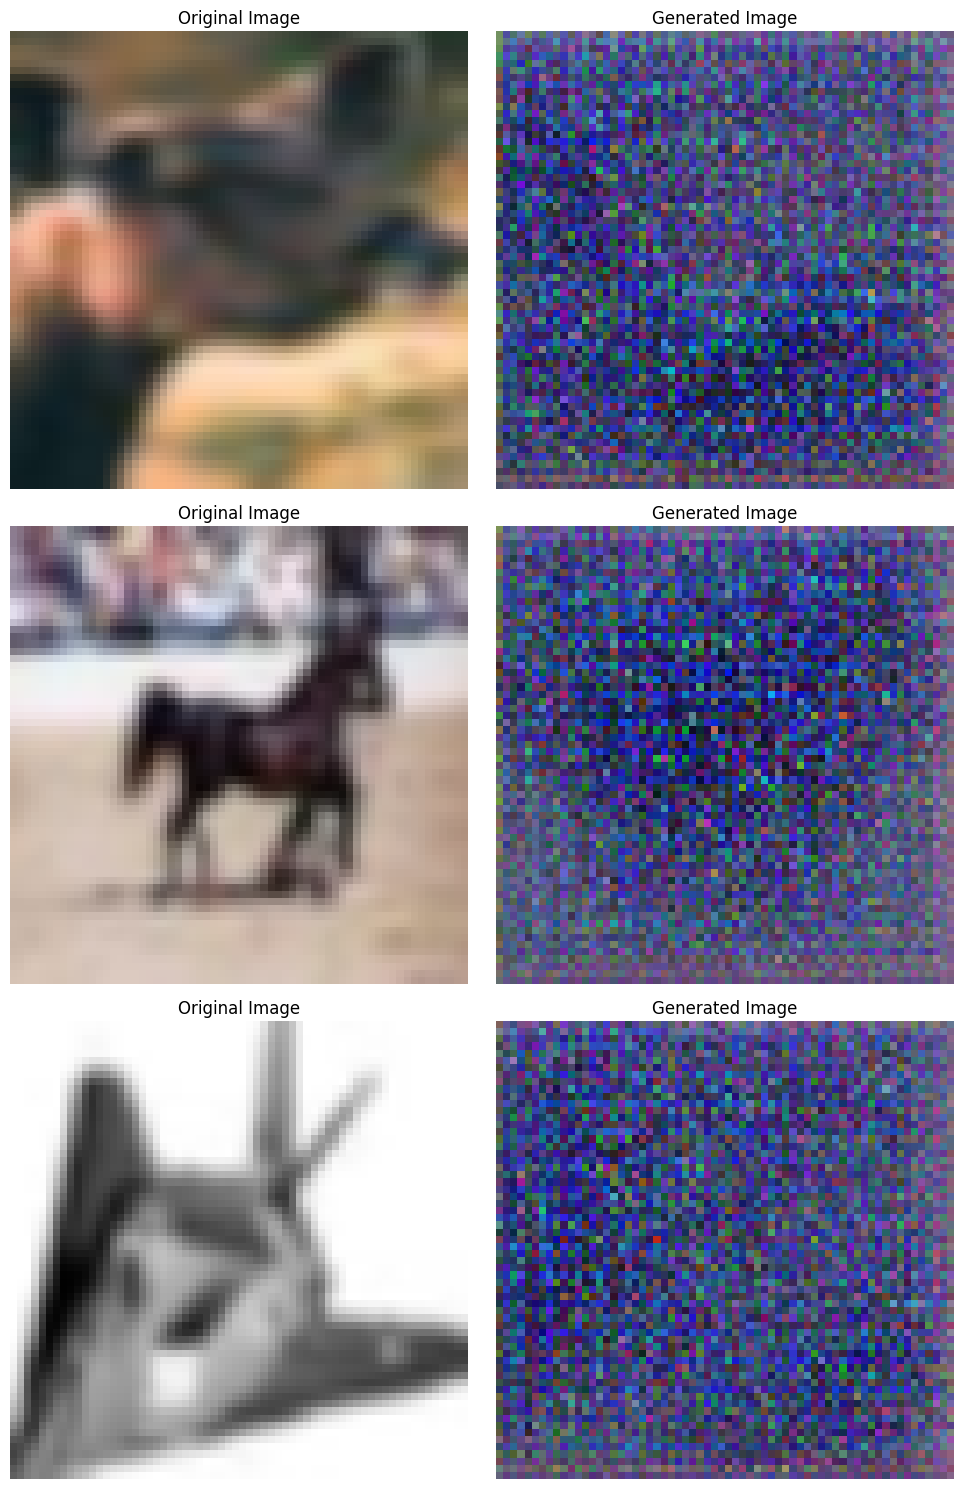

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/5] Loss_G: 9.1433 Loss_D_X: 0.1928 Loss_D_Y: 0.1987


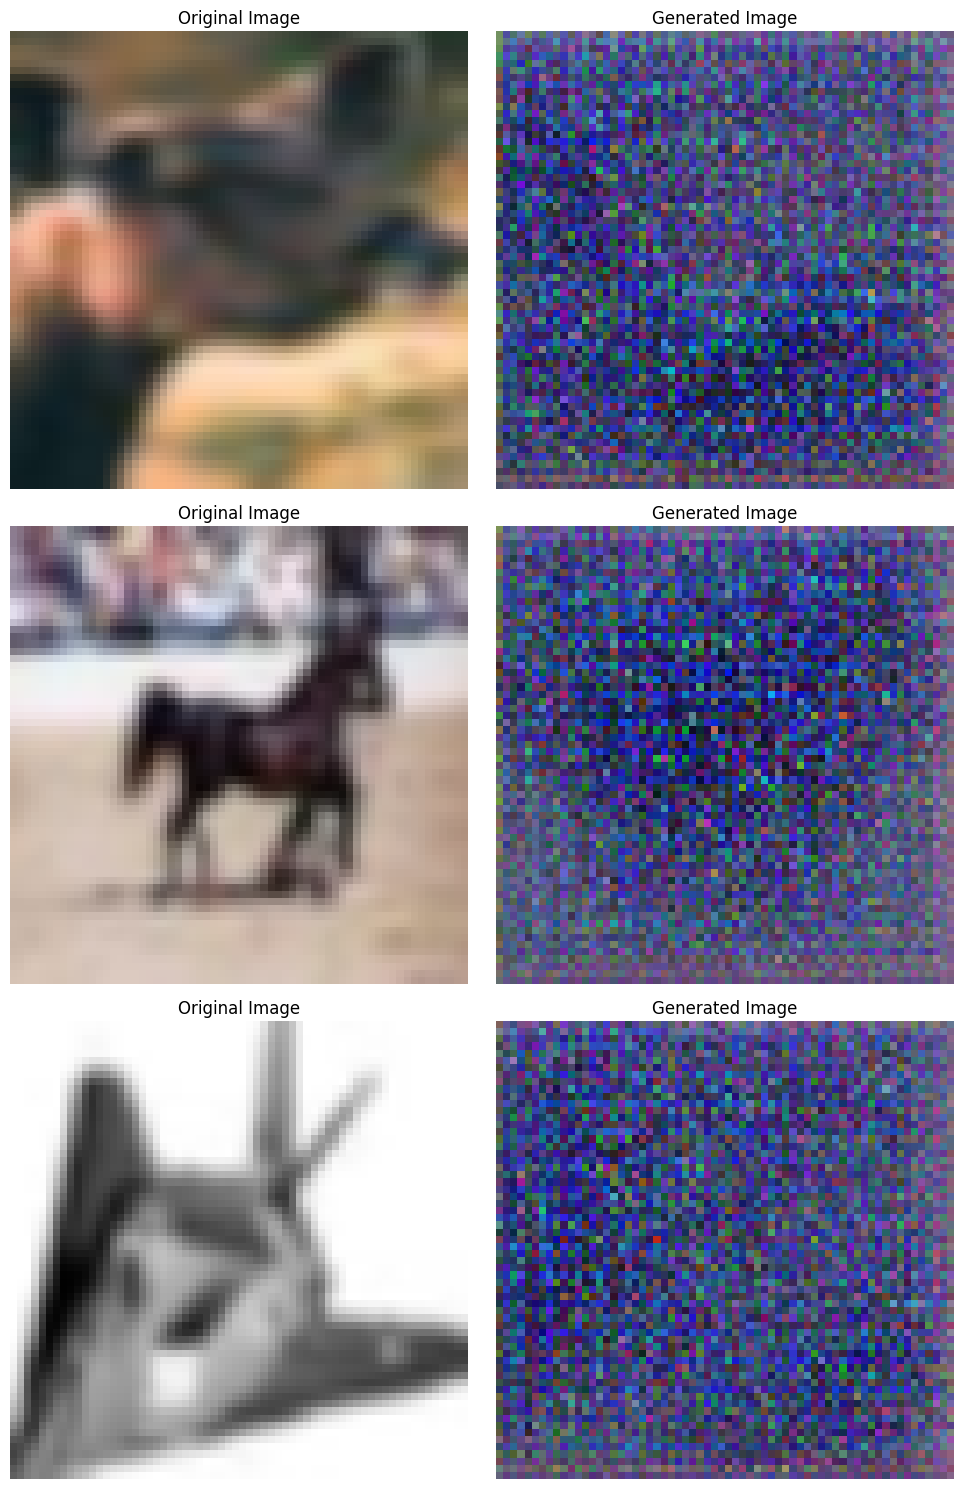

Training at scale: 256x256
Files already downloaded and verified


  0%|          | 0/75 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 59.06 MiB is free. Process 2344 has 14.69 GiB memory in use. Of the allocated memory 13.17 GiB is allocated by PyTorch, and 1.40 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [14]:
# notebook/main.ipynb

import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
from lib.models import ProgressiveGenerator, ProgressiveDiscriminator
from lib.losses import (
    discriminator_loss, generator_loss, cycle_consistency_loss, identity_loss
)
from lib.data_loader import get_dataloader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create directories
os.makedirs('checkpoints', exist_ok=True)

# Initialize models
G_XtoY = ProgressiveGenerator().to(device)
G_YtoX = ProgressiveGenerator().to(device)
D_X = ProgressiveDiscriminator().to(device)
D_Y = ProgressiveDiscriminator().to(device)

# Optimizers
g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())
d_params = list(D_X.parameters()) + list(D_Y.parameters())
g_optimizer = Adam(g_params, lr=2e-4, betas=(0.5, 0.999))
d_optimizer = Adam(d_params, lr=2e-4, betas=(0.5, 0.999))

# Training settings
epochs_per_scale = 5
start_scale = G_XtoY.start_scale
max_scale = G_XtoY.max_scale
lambda_cycle = 10.0
lambda_identity = 5.0
initial_lr = 2e-4

# Training loop
scale = start_scale
while scale <= max_scale:
    print(f"Training at scale: {scale}x{scale}")
    # Data loaders
    transform = transforms.Compose([
        transforms.Resize((scale, scale)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for RGB images
    ])
    dataloader_X = get_dataloader('cifar10', './data', transform, batch_size=16)
    dataloader_Y = get_dataloader('monet', './data/monet', transform, batch_size=16)
    dataloader = zip(dataloader_X, dataloader_Y)

    for epoch in range(1, epochs_per_scale + 1):
        # For collecting examples
        example_originals = []
        example_generated = []

        for i, ((real_X, _), real_Y) in enumerate(tqdm(dataloader, total=min(len(dataloader_X), len(dataloader_Y)))):
            real_X = real_X.to(device)
            real_Y = real_Y.to(device)
            # ------------------
            #  Train Generators
            # ------------------
            g_optimizer.zero_grad()
            # Identity loss
            same_X = G_YtoX(real_X)
            loss_identity_X = identity_loss(real_X, same_X, lambda_identity)
            same_Y = G_XtoY(real_Y)
            loss_identity_Y = identity_loss(real_Y, same_Y, lambda_identity)
            # GAN loss
            fake_Y = G_XtoY(real_X)
            pred_fake = D_Y(fake_Y)
            loss_GAN_XtoY = generator_loss(pred_fake)
            fake_X = G_YtoX(real_Y)
            pred_fake = D_X(fake_X)
            loss_GAN_YtoX = generator_loss(pred_fake)
            # Cycle consistency loss
            recov_X = G_YtoX(fake_Y)
            loss_cycle_X = cycle_consistency_loss(real_X, recov_X, lambda_cycle)
            recov_Y = G_XtoY(fake_X)
            loss_cycle_Y = cycle_consistency_loss(real_Y, recov_Y, lambda_cycle)
            # Total loss
            loss_G = (
                loss_identity_X + loss_identity_Y +
                loss_GAN_XtoY + loss_GAN_YtoX +
                loss_cycle_X + loss_cycle_Y
            )
            loss_G.backward()
            g_optimizer.step()
            # -----------------------
            #  Train Discriminators
            # -----------------------
            d_optimizer.zero_grad()
            # Discriminator X
            pred_real = D_X(real_X)
            pred_fake = D_X(fake_X.detach())
            loss_D_X = discriminator_loss(pred_real, pred_fake)
            loss_D_X.backward()
            # Discriminator Y
            pred_real = D_Y(real_Y)
            pred_fake = D_Y(fake_Y.detach())
            loss_D_Y = discriminator_loss(pred_real, pred_fake)
            loss_D_Y.backward()
            d_optimizer.step()

            # Collect examples
            if i < 3:
                # Detach to prevent memory leaks
                example_originals.append(real_X.cpu())
                example_generated.append(fake_Y.cpu())

        print(f"Epoch [{epoch}/{epochs_per_scale}] Loss_G: {loss_G.item():.4f} Loss_D_X: {loss_D_X.item():.4f} Loss_D_Y: {loss_D_Y.item():.4f}")
        # Display sample images
        originals = torch.cat(example_originals, 0)
        generated = torch.cat(example_generated, 0)

        # Denormalize images for visualization
        def denormalize(tensors):
            return tensors * 0.5 + 0.5

        # Convert tensors to numpy arrays
        originals = denormalize(originals).detach().cpu().numpy().transpose(0, 2, 3, 1)
        generated = denormalize(generated).detach().cpu().numpy().transpose(0, 2, 3, 1)

        # Plot images
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
        for idx in range(3):
            axes[idx, 0].imshow(np.clip(originals[idx], 0, 1))
            axes[idx, 0].axis('off')
            axes[idx, 0].set_title('Original Image')
            axes[idx, 1].imshow(np.clip(generated[idx], 0, 1))
            axes[idx, 1].axis('off')
            axes[idx, 1].set_title('Generated Image')
        plt.tight_layout()
        plt.show()

    # Increase scale
    G_XtoY.increase_scale()
    G_YtoX.increase_scale()
    D_X.increase_scale()
    D_Y.increase_scale()
    # Adjust learning rates if needed
    scale *= 2